In [90]:
from typing import Dict, List, Tuple

import os
import argparse
from functools import lru_cache
from random import seed
import json

import numpy as np
from skimage.io import imsave, imshow
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables import Keypoint, KeypointsOnImage

from image import read_rgb
import affordance_model
import action_regression_model
from common import save_chkpt, load_chkpt
import cv2
import numpy as np
from train import *
from affordance_model import *
from common import *

In [3]:
import affordance_model
import action_regression_model

In [4]:
import torchvision.transforms.functional as TF

In [291]:
dataset_dir = './data/labels'
raw_dataset = RGBDataset(dataset_dir)

In [292]:
data_torch = raw_dataset[8]

In [293]:
rgb = data_torch['rgb']
center_point = data_torch['center_point']
true_angle = data_torch['angle']

In [294]:
device = torch.device('cuda')

In [295]:
rgb = np.array(rgb)

In [296]:
true_angle_index = int(angle / 22.5)

In [297]:
result = []
print("rgb_obs.shape : {}".format(rgb.shape))
for i in range(8):
    seq = iaa.Sequential([iaa.Rotate(i * -22.5)])
    rgb_rot = seq(image=rgb)
    result.append(rgb_rot)
input_value = torch.from_numpy(np.stack(result)).permute(0, 3, 1, 2).type(torch.float32).to(device)
with torch.no_grad():
    prediction = model.predict(input_value)
index = ((prediction == torch.max(prediction)).nonzero())[0]

rgb_obs.shape : (128, 128, 3)


In [298]:
coord = (index[3].item(), index[2].item())
angle = index[0].item() * 22.5
input_value = np.array(input_value.cpu())
prediction = np.array(prediction.cpu())
vis_list = []
for i in range(8):
    input = input_value[i,...]
    target = prediction[i,...]
    vis_image = visualize(input, target)
    vis_image[127, :, :] = 127
    vis_list.append(vis_image)
    if index[0].item() == i:
        draw_grasp(vis_image, coord, 0.0)
vis_img = np.concatenate([
    np.concatenate([vis_list[0], vis_list[1]], axis = 1),
    np.concatenate([vis_list[2], vis_list[3]], axis = 1),
    np.concatenate([vis_list[4], vis_list[5]], axis = 1),
    np.concatenate([vis_list[6], vis_list[7]], axis = 1),
], axis=0)

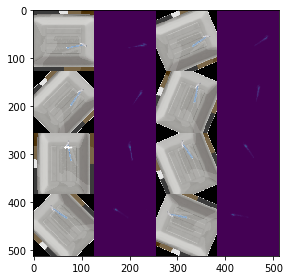

In [299]:
imshow(vis_img)

In [270]:
index

tensor([  4,   0, 102,  55], device='cuda:0')

In [261]:
output = prediction[4,...]

In [262]:
(output == np.max(output)).nonzero()

(array([0]), array([102]), array([55]))

In [260]:
(prediction == np.max(prediction)).nonzero()

(array([4]), array([0]), array([102]), array([55]))

In [263]:
cmap = cm.get_cmap('viridis')

In [264]:
pred_img = cmap(output[0])[...,:3]

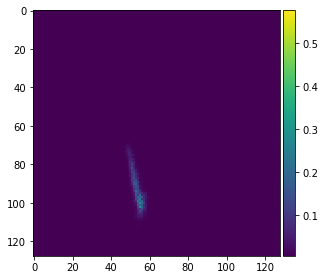

In [265]:
imshow(pred_img)

In [267]:
pred_img[102, 55, :] = 1

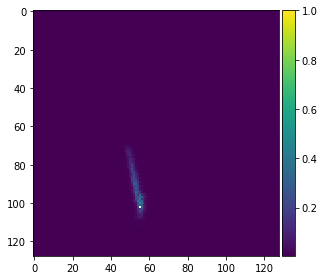

In [268]:
imshow(pred_img)

In [266]:
(pred_img == np.max(pred_img)).nonzero()

(array([102]), array([55]), array([1]))

In [274]:
pred_img.shape

(128, 128, 3)

In [272]:
draw_grasp(pred_img, (102, 55), 0.)

error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'polylines'
> Overload resolution failed:
>  - Layout of the output array img is incompatible with cv::Mat
>  - Expected Ptr<cv::UMat> for argument 'img'


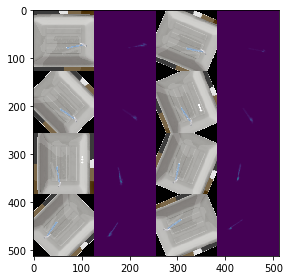

In [231]:
imshow(vis_img)

In [192]:
index = ((prediction == torch.max(prediction)).nonzero())[0]

In [193]:
index

tensor([  4,   0, 102,  55], device='cuda:0')

In [197]:
prediction[4,0,91, 75]

tensor(-14.0110, device='cuda:0', grad_fn=<SelectBackward0>)

In [184]:
prediction.shape

(8, 1, 128, 128)

In [185]:
center_point

tensor([91., 75.])

In [186]:
prediction[4,0,91,75]

8.2244406e-07

In [188]:
prediction.max()

0.5155757

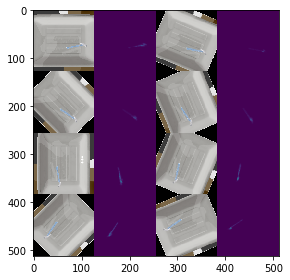

In [180]:
imshow(vis_img)

In [177]:
np.array(prediction).argmax(keepdim=True)

TypeError: argmax() got an unexpected keyword argument 'keepdim'

In [159]:
index = ((prediction == torch.max(prediction)).nonzero())[0]

In [160]:
index

tensor([  4,   0, 102,  55], device='cuda:0')

In [169]:
def visualize(input: np.ndarray, output: np.ndarray, 
        target: Optional[np.ndarray]=None) -> np.ndarray:
    """
    Visualize rgb input and affordance as a single rgb image.
    """
    cmap = cm.get_cmap('viridis')
    in_img = np.moveaxis(input, 0, -1)
    pred_img = cmap(output[0])[...,:3]
    row = [in_img, pred_img]
    if target is not None:
        gt_img = cmap(target[0])[...,:3]
        row.append(gt_img)
    img = (np.concatenate(row, axis=1)*255).astype(np.uint8)
    return img

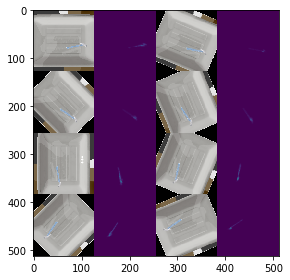

In [171]:
imshow(vis_img)

In [134]:
shape

(128, 128, 3)

In [135]:
kps = KeypointsOnImage([
    Keypoint(x=center_point[0], y=center_point[1]),
], shape=shape)

seq = iaa.Sequential([
    iaa.Rotate(-angle.item())
])


In [136]:
image_aug, kps_aug = seq(image=np.array(rgb), keypoints=kps)
x_aug = kps_aug[0].x
y_aug = kps_aug[0].y


In [141]:
target = get_gaussian_scoremap((img_h, img_w), np.array([x_aug, y_aug]))
target = np.expand_dims(target, axis=0)

In [142]:
target.shape

(1, 128, 128)

In [138]:
target_aug = (np.stack([np.moveaxis(target, 0, -1)]*3, axis=2).squeeze() * 255).astype(int)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


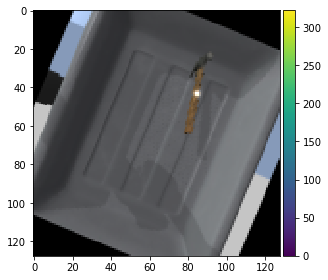

In [139]:
imshow(image_aug + target_aug)

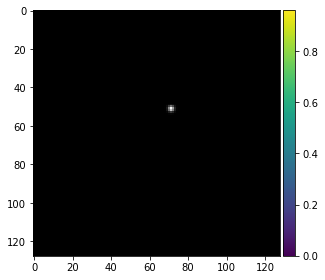

In [117]:
imshow(target_aug)

In [70]:
np.array(rgb.shape)

array([128, 128,   3])

In [65]:
center_point

tensor([75., 65.])

In [66]:
angle

tensor(45.)

In [19]:
center_point_x, center_point_y = center_point[0].item(), center_point[1].item()
left_coord, right_coord = get_finger_points(np.array([center_point_x, center_point_y]), angle.item())

In [23]:
center_point_x

75.0

In [20]:
rgb.shape

torch.Size([128, 128, 3])

In [32]:
x = np.array(rgb)

In [33]:
draw_grasp(x, center_point, angle)

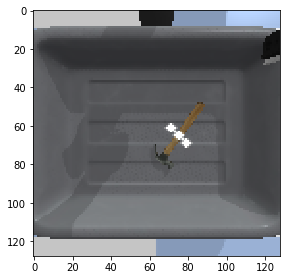

In [34]:
imshow(x)

In [55]:
kps = KeypointsOnImage([
            Keypoint(x=left_coord[0], y=left_coord[1]),
            Keypoint(x=right_coord[0], y=right_coord[1])
        ], shape=rgb.shape)

In [56]:
angle_delta = 180/8
aug_pipeline = iaa.Sometimes(0.99, iaa.Affine(
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-angle_delta/2,angle_delta/2),
        ))

In [57]:
seq = iaa.Sequential([
    aug_pipeline
])
image_aug, kps_aug = seq(image=np.array(rgb), keypoints=kps)

In [58]:
left_coord_aug_x = kps_aug[0].x
left_coord_aug_y = kps_aug[0].y
right_coord_aug_x = kps_aug[1].x
right_coord_aug_y = kps_aug[1].y

center_coord_aug, angle_aug = get_center_angle(np.array([left_coord_aug_x, left_coord_aug_y]),
                                               np.array([right_coord_aug_x, right_coord_aug_y]))


In [67]:
data = {
    'rgb': image_aug,
    'center_point': np.array(center_coord_aug, dtype=np.float32),
    'angle': np.array(angle_aug, dtype=np.float32)
}
data_torch = dict()
for key, value in data.items():
    data_torch[key] = torch.from_numpy(value)

In [69]:
data_torch['rgb'].shape

torch.Size([128, 128, 3])

In [59]:
draw_grasp(image_aug, center_coord_aug, angle_aug)

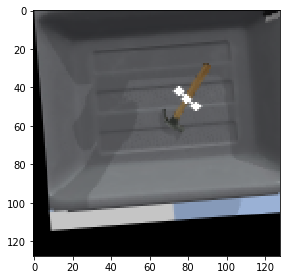

In [61]:
imshow(image_aug)

In [5]:
model_class = affordance_model.AffordanceModel

In [6]:
model_dir = os.path.join('data', 'affordance')
chkpt_path = os.path.join(model_dir, 'best.ckpt')

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model_class()
model.to(device)
load_chkpt(model, chkpt_path, device)
model.eval()

epoch, model_loss: 100 0.0017366716638207436


AffordanceModel(
  (inc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (down1): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
  )
  (down2): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
  )
  (upconv1): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (conv1): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (upconv2): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  (conv2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (outc): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
)

In [8]:
labels_path =  '/home/adityasidharta/columbia/columbia_robotics/hw4/data/labels/labels.json'
labels = json.load(open(labels_path, 'r'))
label_pairs = list()
for key, value in labels.items():
    for i, label in enumerate(value):
        label_pairs.append((
            '{}_{}'.format(key, i),
            label
        ))
labels_dir = '/home/adityasidharta/columbia/columbia_robotics/hw4/data/labels/'
label_pairs = label_pairs
key, label = label_pairs[5]
img_path = os.path.join(labels_dir, '{}_rgb.png'.format(key))
rgb = read_rgb(img_path)

In [9]:
coord, angle, vis_img = model.predict_grasp(rgb)

selected index : tensor([ 0,  0, 52, 85], device='cuda:0')
torch.argmax : 6741
prediction shape : torch.Size([8, 1, 128, 128])


In [10]:
a = np.arange(0, 8*1*128*128).reshape(8,1,128,128)
(a == 6691).nonzero()

(array([0]), array([0]), array([52]), array([35]))

In [ ]:

train_raw_dataset, test_raw_dataset = random_split(
    raw_dataset, [int(0.9 * len(raw_dataset)), len(raw_dataset) - int(0.9 * len(raw_dataset))])
dataset_class = affordance_model.AffordanceDataset
train_dataset = dataset_class(train_raw_dataset)

In [ ]:
BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

In [ ]:
next(iter(train_loader))

In [ ]:
imshow(vis_img)

In [ ]:
imshow(rgb)

In [ ]:
rg = torch.from_numpy(rgb).permute(2, 0, 1)

In [ ]:
result = TF.rotate(rg, 30)

In [ ]:
imshow(np.array(result.permute(1, 2, 0)))

In [ ]:
result = []
for i in range(8):
    seq = iaa.Sequential([iaa.Rotate(i * 22.5)])
    rgb_rot = seq(image=rgb)
    result.append(rgb_rot)
input_value = torch.from_numpy(np.stack(result)).permute(0, 3, 1, 2).type(torch.float32).to(device)

In [ ]:
input_value

In [ ]:
model.to(device)

In [ ]:
with torch.no_grad():
    prediction = model.predict(input_value)

In [ ]:
prediction.shape

In [ ]:
prediction

In [ ]:
index = ((prediction == torch.max(prediction)).nonzero())[0]

In [ ]:
x = input_value.to(torch.device('cpu'))

In [ ]:
x.cpu()

In [ ]:
input_value = input_value.cpu()
prediction = prediction.cpu()

In [ ]:
input_value

In [ ]:
visualize(np.array(input_value), np.array(prediction))

In [ ]:
in_img = np.moveaxis(np.array(input_value), 0, -1)

In [ ]:
in_img.shape

In [ ]:
input_value.shape

In [ ]:
from typing import Tuple, Optional, Dict

import numpy as np
from matplotlib import cm
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import imgaug.augmenters as iaa
from imgaug.augmentables import Keypoint, KeypointsOnImage

from common import draw_grasp


In [ ]:
cmap = cm.get_cmap('viridis')

In [ ]:
input_value = np.array(input_value.cpu())
prediction = np.array(prediction.cpu())

In [ ]:
input = input_value[0,...]
target = prediction[0,...]

In [ ]:
vis_image = visualize(input, target)

In [ ]:
vis_image.shape

In [ ]:
vis_image[127, :, :] = int(255 / 2)

In [ ]:
imshow(vis_image)

In [ ]:
vis_list = []

In [ ]:
for i in range(8):
    input = input_value[i,...]
    target = prediction[i,...]
    vis_list.append(visualize(input, target))

In [ ]:
visualize(input, target).shape

In [ ]:
vis_list = []
for i in range(8):
    input = input_value[i,...]
    target = prediction[i,...]
    vis_image = visualize(input, target)
    vis_image[127, :, :] = 0
    vis_list.append(vis_image)
vis_img = np.concatenate([
    np.concatenate([vis_list[0], vis_list[1]], axis = 1),
    np.concatenate([vis_list[2], vis_list[3]], axis = 1),
    np.concatenate([vis_list[4], vis_list[5]], axis = 1),
    np.concatenate([vis_list[6], vis_list[7]], axis = 1),
], axis=0)

In [ ]:
imshow(vis_img)

In [ ]:
prediction.shape

In [ ]:
imshow(np.concatenate([[vis_list[0], vis_list[1]],
         [vis_list[2], vis_list[3]],
         [vis_list[4], vis_list[5]],
         [vis_list[6], vis_list[7]],]))

In [ ]:
prediction.shape

In [ ]:
pred_img = cmap(np.array(prediction)[0])[...,:3]

In [ ]:
pred_img.shape

In [ ]:
visualize(input_value.cpu(), prediction.cpu())

In [ ]:
torch.argmax(prediction)

In [ ]:
index

In [ ]:
result = []
for i in range(8):
    seq = iaa.Sequential([iaa.Rotate(i * 22.5)])
    rgb_rot = seq(image=rgb)
    result.append(rgb_rot)

In [ ]:
input_value = torch.from_numpy(np.stack(result)).to(device)

In [ ]:
model = affordance_model.AffordanceModel()

In [ ]:
input_value.shape

In [ ]:
model.predict(input_value)

In [ ]:
def read_rgb_cached(file_path):
    return read_rgb(file_path)

In [ ]:
angle_delta = 180/8
aug_pipeline = iaa.Sometimes(0.7, iaa.Affine(
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-angle_delta/2,angle_delta/2),
        ))

In [ ]:
def get_center_angle(
        left_coord: np.ndarray, 
        right_coord: np.ndarray
        ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Convert the pixel coordinate of left and right fingers to 
    gripper center and angle.
    return:
    center_coord: np.ndarray([x,y], dtype=np.float32)
    angle: float
    """
    # TODO: complete this function
    # Why do we need this function?
    # Hint: read get_finger_points
    # Hint: it's a hack
    # ===============================================================================
    center_coord = np.array([(left_coord[0] + right_coord[0]) / 2, (left_coord[1] + right_coord[1]) / 2])
    x, y = right_coord - center_coord
    angle = np.arctan2(y, x) * 180. / np.pi
    # ===============================================================================
    return center_coord, angle


In [ ]:
center_point_x, center_point_y = center_point[0].item(), center_point[1].item()
left_coord, right_coord = get_finger_points(np.array([center_point_x, center_point_y]), angle.item())
kps = KeypointsOnImage([
    Keypoint(x=left_coord[0], y=left_coord[1]),
    Keypoint(x=right_coord[0], y=right_coord[1])
], shape=rgb.shape)
seq = iaa.Sequential([
    aug_pipeline
])
image_aug, kps_aug = seq(image=np.array(rgb), keypoints=kps)
left_coord_aug_x = kps_aug[0].x
left_coord_aug_y = kps_aug[0].y
right_coord_aug_x = kps_aug[1].x
right_coord_aug_y = kps_aug[1].y

center_coord_aug, angle_aug = get_center_angle(np.array([left_coord_aug_x, left_coord_aug_y]),
                                               np.array([right_coord_aug_x, right_coord_aug_y]))



In [ ]:
imshow(kps.draw_on_image(rgb))

In [ ]:
imshow(kps_aug.draw_on_image(image_aug))

In [ ]:
torch.from_numpy(image_aug).shape

In [ ]:
center_coord_aug

In [ ]:
np.array(angle_aug).shape

In [ ]:
imshow(rgb)

In [ ]:
np.arange(0., 360., 360./8.)

In [ ]:
result = []
for i in np.arange(0., 360., 360./8.):
    seq = iaa.Sequential([iaa.Rotate(i)])
    rgb_rot = seq(image=rgb)
    result.append(rgb_rot)

In [ ]:
import torch

In [ ]:
device = torch.device('cuda')

In [ ]:
input_value = torch.from_numpy(np.stack(result)).to(device)

In [ ]:
input_value.shape

In [ ]:
((input_value==torch.max(input_value)).nonzero())[0]

In [ ]:
input_value[  6,  21,   0,   2]

In [ ]:
center_point = np.array(label[:2], dtype=np.float32)

In [ ]:
angle_point = np.array(label[2], dtype=np.float32)

In [ ]:
rgb = torch.from_numpy(rgb)
center_point = torch.from_numpy(center_point)
angle = torch.from_numpy(angle_point)

In [ ]:
angle.item()


In [ ]:
kps = KeypointsOnImage([
    Keypoint(x=center_point[0], y=center_point[1]),
], shape=rgb.shape)

seq = iaa.Sequential([
    iaa.Rotate(-angle.item())
])

image_aug, kps_aug = seq(image=np.array(rgb), keypoints=kps)
x_aug = kps_aug[0].x
y_aug = kps_aug[0].y


In [ ]:
image_after = kps_aug.draw_on_image(image_aug, size = 3)

In [ ]:
imshow(np.array(rgb))

In [ ]:
result = []
for i in range(8):
    seq = iaa.Sequential([iaa.Rotate(i * 22.5)])
    rgb_rot = seq(image=rgb)
    result.append(rgb_rot)

In [ ]:
input_value = torch.from_numpy(np.stack(result)).to(device)

In [ ]:
visualize(np.array())

In [ ]:
target = []

a = np.zeros([128, 128, 1])


In [ ]:
from typing import Tuple, Optional, Dict

import numpy as np
from matplotlib import cm
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import imgaug.augmenters as iaa
from imgaug.augmentables import Keypoint, KeypointsOnImage

from common import draw_grasp


In [ ]:
def visualize(input: np.ndarray, output: np.ndarray, 
            target: Optional[np.ndarray]=None) -> np.ndarray:
        """
        Visualize rgb input and affordance as a single rgb image.
        """
        cmap = cm.get_cmap('viridis')
        in_img = np.moveaxis(input, 0, -1)
        pred_img = cmap(output[0])[...,:3]
        row = [in_img, pred_img]
        if target is not None:
            gt_img = cmap(target[0])[...,:3]
            row.append(gt_img)
        img = (np.concatenate(row, axis=1)*255).astype(np.uint8)
        return img

In [ ]:
visualize

In [ ]:
image_aug.shape

In [ ]:
torch.from_numpy(image_aug).permute(2, 0, 1).type(torch.float32)

In [ ]:
center_point

In [ ]:
kps = KeypointsOnImage([
    Keypoint(x=center_point[0], y=center_point[1]),
], shape=rgb.shape)

seq = iaa.Sequential([
    iaa.Rotate(-angle_point.item())
])


In [ ]:
image_aug, kps_aug = seq(image=np.array(rgb), keypoints=kps)

In [ ]:
kps_aug[0].x

In [ ]:
kps_aug[0].y

In [ ]:
image_after = kps_aug.draw_on_image(image_aug, size=7)

In [ ]:
imshow(image_aug)

In [ ]:
def get_gaussian_scoremap(
        shape: Tuple[int, int], 
        keypoint: np.ndarray, 
        sigma: float=1, dtype=np.float32) -> np.ndarray:
    """
    Generate a image of shape=:shape:, generate a Gaussian distribtuion
    centered at :keypont: with standard deviation :sigma: pixels.
    keypoint: shape=(2,)
    """
    coord_img = np.moveaxis(np.indices(shape),0,-1).astype(dtype)
    sqrt_dist_img = np.square(np.linalg.norm(
        coord_img - keypoint[::-1].astype(dtype), axis=-1))
    scoremap = np.exp(-0.5/np.square(sigma)*sqrt_dist_img)
    return scoremap

In [ ]:
target = get_gaussian_scoremap((128, 128), np.array([x_aug, y_aug]))

In [ ]:
target = np.expand_dims(target, axis=1)

In [ ]:
imshow(target)

In [ ]:
import numpy as np

def angle_between(p1, p2):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.rad2deg((ang1 - ang2) % (2 * np.pi))


In [ ]:
def get_finger_points(
        center_point: np.ndarray, 
        angle: float, width: int=10
        ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Given the pick position and angle in pixel space,
    return the position of left and right fingers of the gripper
    given the gripper width.
    """
    center_coord = np.array(center_point, dtype=np.float32)
    rad = angle / 180 * np.pi
    direction = np.array([np.cos(rad), np.sin(rad)], dtype=np.float32)
    left_coord = center_coord - direction * width
    right_coord = center_coord + direction * width
    return left_coord, right_coord


In [ ]:
center_points

In [ ]:
center_points = np.array([50., 60.])

In [ ]:
left, right = get_finger_points(center_points, 69)

In [ ]:
center_points = np.array([(left[0] + right[0]) / 2, (left[1] + right[1]) / 2])

In [ ]:
x, y = right - center_points

In [ ]:
np.arctan2(y, x) * 180. / np.pi

In [ ]:
center_points

In [ ]:
angle_between(center_points, right)

In [ ]:
imshow( + image_aug)

In [ ]:
label

In [ ]:
from skimage import draw

In [ ]:
rr, cc = draw.circle_perimeter(label[1], label[0], 3)
rgb[rr, cc] = 1

In [ ]:
rr, cc

In [ ]:
rgb.shape

In [ ]:
imshow(rgb)

In [ ]:
key, label = label_pairs[7]
img_path = os.path.join(labels_dir, '{}_rgb.png'.format(key))
rgb = read_rgb_cached(img_path)

In [ ]:
rgb

In [ ]:
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables import Keypoint, KeypointsOnImage

image = rgb
kps = KeypointsOnImage([
    Keypoint(x=label[0], y=label[1]),
], shape=image.shape)

seq = iaa.Sequential([
    iaa.Rotate(-label[2]) # rotate by exactly 10deg and scale to 50-70%, affects keypoints
])

# Augment keypoints and images.
image_aug, kps_aug = seq(image=image, keypoints=kps)

# print coordinates before/after augmentation (see below)
# use after.x_int and after.y_int to get rounded integer coordinates
for i in range(len(kps.keypoints)):
    before = kps.keypoints[i]
    after = kps_aug.keypoints[i]
    print("Keypoint %d: (%.8f, %.8f) -> (%.8f, %.8f)" % (
        i, before.x, before.y, after.x, after.y)
    )

# image with keypoints before/after augmentation (shown below)
image_before = kps.draw_on_image(image, size=7)
image_after = kps_aug.draw_on_image(image_aug, size=7)

In [ ]:
imshow(image_before)

In [ ]:
imshow(image_after)